In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 시각화
import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
from pylab import rcParams

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [5]:
# '탄산음료'만 빼서 df생성
item = '탄산음료'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

In [6]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

In [7]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [8]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = gs_day_w.loc[:,list_col]
target = gs_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [9]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [10]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


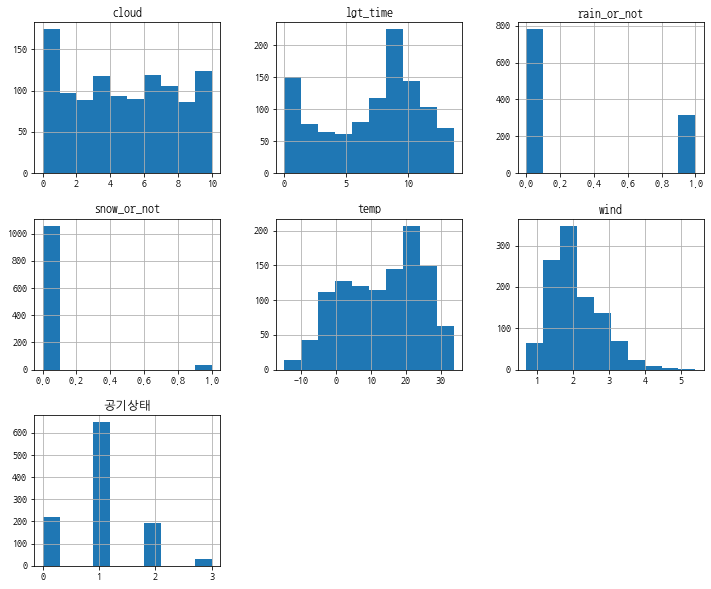

In [11]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

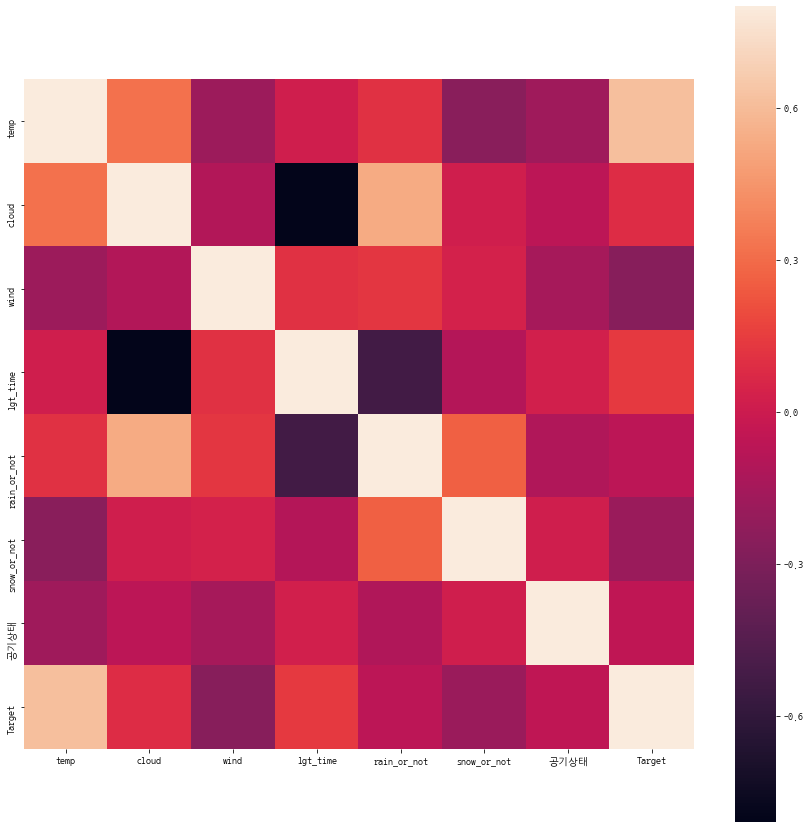

In [12]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [13]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [16]:
combined.head(1)

,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2
0,1.2,7.0,1.6,2.1,0,0,0,0,1


In [ ]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)

In [45]:
combined.head(1)

,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2
0,1.2,7.0,1.6,2.1,0,0,0,0,1


In [67]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [47]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [48]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [22]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0722 13:43:46.789439  1820 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0722 13:43:46.897152  1820 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/1000
585/585 [==============================] - 0s 495us/step - loss: 5957.6229 - mean_absolute_error: 5957.6229 - val_loss: 5846.2215 - val_mean_absolute_error: 5846.2215

Epoch 00001: val_loss improved from inf to 5846.22147, saving model to 탄산음료date-Weights-001--5846.22147-cat02-vf05.hdf5
Epoch 2/1000
585/585 [==============================] - 0s 89us/step - loss: 5406.4151 - mean_absolute_error: 5406.4151 - val_loss: 3875.6167 - val_mean_absolute_error: 3875.6167

Epoch 00002: val_loss improved from 5846.22147 to 3875.61666, saving model to 탄산음료date-Weights-002--3875.61666-cat02-vf05.hdf5
Epoch 3/1000
585/585 [==============================] - 0s 80us/step - loss: 1913.4405 - mean_absolute_error: 1913.4405 - val_loss: 1523.2096 - val_mean_absolute_error: 1523.2096

Epoch 00003: val_loss improved from 3875.61666 to 1523.20956, saving model to 탄산음료date-Weights-003--1523.20956-cat02-vf05.hdf5
Epoch 4/1000
585/585 [=================


Epoch 00032: val_loss did not improve from 1017.30399
Epoch 33/1000
585/585 [==============================] - 0s 73us/step - loss: 1063.6380 - mean_absolute_error: 1063.6380 - val_loss: 1068.5646 - val_mean_absolute_error: 1068.5646

Epoch 00033: val_loss did not improve from 1017.30399
Epoch 34/1000
585/585 [==============================] - 0s 78us/step - loss: 1047.2071 - mean_absolute_error: 1047.2071 - val_loss: 1028.3430 - val_mean_absolute_error: 1028.3430

Epoch 00034: val_loss did not improve from 1017.30399
Epoch 35/1000
585/585 [==============================] - 0s 70us/step - loss: 1051.5456 - mean_absolute_error: 1051.5456 - val_loss: 1044.7421 - val_mean_absolute_error: 1044.7421

Epoch 00035: val_loss did not improve from 1017.30399
Epoch 36/1000
585/585 [==============================] - 0s 72us/step - loss: 1047.0353 - mean_absolute_error: 1047.0353 - val_loss: 1066.4818 - val_mean_absolute_error: 1066.4818

Epoch 00036: val_loss did not improve from 1017.30399
Epoch

585/585 [==============================] - 0s 75us/step - loss: 996.2225 - mean_absolute_error: 996.2225 - val_loss: 932.9157 - val_mean_absolute_error: 932.9157

Epoch 00066: val_loss did not improve from 892.03541
Epoch 67/1000
585/585 [==============================] - 0s 87us/step - loss: 1006.8100 - mean_absolute_error: 1006.8100 - val_loss: 908.7632 - val_mean_absolute_error: 908.7632

Epoch 00067: val_loss did not improve from 892.03541
Epoch 68/1000
585/585 [==============================] - 0s 77us/step - loss: 993.5766 - mean_absolute_error: 993.5766 - val_loss: 899.4311 - val_mean_absolute_error: 899.4311

Epoch 00068: val_loss did not improve from 892.03541
Epoch 69/1000
585/585 [==============================] - 0s 73us/step - loss: 1008.6559 - mean_absolute_error: 1008.6559 - val_loss: 910.9999 - val_mean_absolute_error: 910.9999

Epoch 00069: val_loss did not improve from 892.03541
Epoch 70/1000
585/585 [==============================] - 0s 72us/step - loss: 1007.4523 - 

585/585 [==============================] - 0s 77us/step - loss: 964.2144 - mean_absolute_error: 964.2144 - val_loss: 877.4626 - val_mean_absolute_error: 877.4626

Epoch 00100: val_loss did not improve from 826.93540
Epoch 101/1000
585/585 [==============================] - 0s 80us/step - loss: 961.6569 - mean_absolute_error: 961.6569 - val_loss: 870.4128 - val_mean_absolute_error: 870.4128

Epoch 00101: val_loss did not improve from 826.93540
Epoch 102/1000
585/585 [==============================] - 0s 78us/step - loss: 966.1900 - mean_absolute_error: 966.1900 - val_loss: 881.8453 - val_mean_absolute_error: 881.8453

Epoch 00102: val_loss did not improve from 826.93540
Epoch 103/1000
585/585 [==============================] - 0s 77us/step - loss: 991.7249 - mean_absolute_error: 991.7249 - val_loss: 896.7732 - val_mean_absolute_error: 896.7732

Epoch 00103: val_loss did not improve from 826.93540
Epoch 104/1000
585/585 [==============================] - 0s 72us/step - loss: 993.7585 - m

585/585 [==============================] - 0s 66us/step - loss: 956.3614 - mean_absolute_error: 956.3614 - val_loss: 876.2657 - val_mean_absolute_error: 876.2657

Epoch 00135: val_loss did not improve from 786.60292
Epoch 136/1000
585/585 [==============================] - 0s 72us/step - loss: 952.8653 - mean_absolute_error: 952.8653 - val_loss: 831.0022 - val_mean_absolute_error: 831.0022

Epoch 00136: val_loss did not improve from 786.60292
Epoch 137/1000
585/585 [==============================] - 0s 87us/step - loss: 955.8947 - mean_absolute_error: 955.8947 - val_loss: 857.0341 - val_mean_absolute_error: 857.0341

Epoch 00137: val_loss did not improve from 786.60292
Epoch 138/1000
585/585 [==============================] - 0s 73us/step - loss: 940.0148 - mean_absolute_error: 940.0148 - val_loss: 858.0142 - val_mean_absolute_error: 858.0142

Epoch 00138: val_loss did not improve from 786.60292
Epoch 139/1000
585/585 [==============================] - 0s 73us/step - loss: 944.8033 - m


Epoch 00170: val_loss did not improve from 786.60292
Epoch 171/1000
585/585 [==============================] - 0s 80us/step - loss: 920.6506 - mean_absolute_error: 920.6506 - val_loss: 844.3050 - val_mean_absolute_error: 844.3050

Epoch 00171: val_loss did not improve from 786.60292
Epoch 172/1000
585/585 [==============================] - 0s 82us/step - loss: 917.5354 - mean_absolute_error: 917.5354 - val_loss: 860.6535 - val_mean_absolute_error: 860.6535

Epoch 00172: val_loss did not improve from 786.60292
Epoch 173/1000
585/585 [==============================] - 0s 80us/step - loss: 927.2345 - mean_absolute_error: 927.2345 - val_loss: 855.0685 - val_mean_absolute_error: 855.0685

Epoch 00173: val_loss did not improve from 786.60292
Epoch 174/1000
585/585 [==============================] - 0s 75us/step - loss: 918.2755 - mean_absolute_error: 918.2755 - val_loss: 821.5268 - val_mean_absolute_error: 821.5268

Epoch 00174: val_loss did not improve from 786.60292
Epoch 175/1000
585/585

585/585 [==============================] - 0s 84us/step - loss: 900.0778 - mean_absolute_error: 900.0778 - val_loss: 908.5808 - val_mean_absolute_error: 908.5808

Epoch 00206: val_loss did not improve from 786.60292
Epoch 207/1000
585/585 [==============================] - 0s 84us/step - loss: 911.4174 - mean_absolute_error: 911.4174 - val_loss: 828.5448 - val_mean_absolute_error: 828.5448

Epoch 00207: val_loss did not improve from 786.60292
Epoch 208/1000
585/585 [==============================] - 0s 80us/step - loss: 921.3102 - mean_absolute_error: 921.3102 - val_loss: 891.7393 - val_mean_absolute_error: 891.7393

Epoch 00208: val_loss did not improve from 786.60292
Epoch 209/1000
585/585 [==============================] - 0s 78us/step - loss: 962.8931 - mean_absolute_error: 962.8931 - val_loss: 890.9610 - val_mean_absolute_error: 890.9610

Epoch 00209: val_loss did not improve from 786.60292
Epoch 210/1000
585/585 [==============================] - 0s 72us/step - loss: 901.4748 - m

585/585 [==============================] - 0s 72us/step - loss: 913.3748 - mean_absolute_error: 913.3748 - val_loss: 864.6232 - val_mean_absolute_error: 864.6232

Epoch 00241: val_loss did not improve from 776.03934
Epoch 242/1000
585/585 [==============================] - 0s 85us/step - loss: 925.2723 - mean_absolute_error: 925.2723 - val_loss: 928.6060 - val_mean_absolute_error: 928.6060

Epoch 00242: val_loss did not improve from 776.03934
Epoch 243/1000
585/585 [==============================] - 0s 70us/step - loss: 890.2756 - mean_absolute_error: 890.2756 - val_loss: 872.9074 - val_mean_absolute_error: 872.9074

Epoch 00243: val_loss did not improve from 776.03934
Epoch 244/1000
585/585 [==============================] - 0s 72us/step - loss: 885.8943 - mean_absolute_error: 885.8943 - val_loss: 855.6281 - val_mean_absolute_error: 855.6281

Epoch 00244: val_loss did not improve from 776.03934
Epoch 245/1000
585/585 [==============================] - 0s 77us/step - loss: 888.5651 - m


Epoch 00276: val_loss did not improve from 776.03934
Epoch 277/1000
585/585 [==============================] - 0s 87us/step - loss: 877.1328 - mean_absolute_error: 877.1328 - val_loss: 860.4743 - val_mean_absolute_error: 860.4743

Epoch 00277: val_loss did not improve from 776.03934
Epoch 278/1000
585/585 [==============================] - 0s 84us/step - loss: 901.6187 - mean_absolute_error: 901.6187 - val_loss: 886.3813 - val_mean_absolute_error: 886.3813

Epoch 00278: val_loss did not improve from 776.03934
Epoch 279/1000
585/585 [==============================] - 0s 82us/step - loss: 910.5980 - mean_absolute_error: 910.5980 - val_loss: 904.8831 - val_mean_absolute_error: 904.8831

Epoch 00279: val_loss did not improve from 776.03934
Epoch 280/1000
585/585 [==============================] - 0s 75us/step - loss: 876.5379 - mean_absolute_error: 876.5379 - val_loss: 872.8824 - val_mean_absolute_error: 872.8824

Epoch 00280: val_loss did not improve from 776.03934
Epoch 281/1000
585/585

585/585 [==============================] - 0s 94us/step - loss: 860.7667 - mean_absolute_error: 860.7667 - val_loss: 891.7646 - val_mean_absolute_error: 891.7646

Epoch 00312: val_loss did not improve from 776.03934
Epoch 313/1000
585/585 [==============================] - 0s 89us/step - loss: 883.9542 - mean_absolute_error: 883.9542 - val_loss: 961.6257 - val_mean_absolute_error: 961.6257

Epoch 00313: val_loss did not improve from 776.03934
Epoch 314/1000
585/585 [==============================] - 0s 92us/step - loss: 862.7299 - mean_absolute_error: 862.7299 - val_loss: 868.8955 - val_mean_absolute_error: 868.8955

Epoch 00314: val_loss did not improve from 776.03934
Epoch 315/1000
585/585 [==============================] - 0s 80us/step - loss: 869.6932 - mean_absolute_error: 869.6932 - val_loss: 875.3653 - val_mean_absolute_error: 875.3653

Epoch 00315: val_loss did not improve from 776.03934
Epoch 316/1000
585/585 [==============================] - 0s 80us/step - loss: 876.3772 - m


Epoch 00347: val_loss did not improve from 776.03934
Epoch 348/1000
585/585 [==============================] - 0s 99us/step - loss: 871.1258 - mean_absolute_error: 871.1258 - val_loss: 904.1744 - val_mean_absolute_error: 904.1744

Epoch 00348: val_loss did not improve from 776.03934
Epoch 349/1000
585/585 [==============================] - 0s 89us/step - loss: 860.7305 - mean_absolute_error: 860.7305 - val_loss: 913.8399 - val_mean_absolute_error: 913.8399

Epoch 00349: val_loss did not improve from 776.03934
Epoch 350/1000
585/585 [==============================] - 0s 89us/step - loss: 863.3882 - mean_absolute_error: 863.3882 - val_loss: 867.3522 - val_mean_absolute_error: 867.3522

Epoch 00350: val_loss did not improve from 776.03934
Epoch 351/1000
585/585 [==============================] - 0s 90us/step - loss: 855.3993 - mean_absolute_error: 855.3993 - val_loss: 932.0895 - val_mean_absolute_error: 932.0895

Epoch 00351: val_loss did not improve from 776.03934
Epoch 352/1000
585/585

585/585 [==============================] - 0s 118us/step - loss: 867.6173 - mean_absolute_error: 867.6173 - val_loss: 936.6924 - val_mean_absolute_error: 936.6924

Epoch 00383: val_loss did not improve from 776.03934
Epoch 384/1000
585/585 [==============================] - 0s 114us/step - loss: 854.5253 - mean_absolute_error: 854.5253 - val_loss: 887.9786 - val_mean_absolute_error: 887.9786

Epoch 00384: val_loss did not improve from 776.03934
Epoch 385/1000
585/585 [==============================] - 0s 113us/step - loss: 852.2494 - mean_absolute_error: 852.2494 - val_loss: 860.2024 - val_mean_absolute_error: 860.2024

Epoch 00385: val_loss did not improve from 776.03934
Epoch 386/1000
585/585 [==============================] - 0s 107us/step - loss: 851.6788 - mean_absolute_error: 851.6788 - val_loss: 902.2484 - val_mean_absolute_error: 902.2484

Epoch 00386: val_loss did not improve from 776.03934
Epoch 387/1000
585/585 [==============================] - 0s 106us/step - loss: 843.669

585/585 [==============================] - 0s 124us/step - loss: 863.8386 - mean_absolute_error: 863.8386 - val_loss: 884.7865 - val_mean_absolute_error: 884.7865

Epoch 00418: val_loss did not improve from 776.03934
Epoch 419/1000
585/585 [==============================] - 0s 128us/step - loss: 850.3557 - mean_absolute_error: 850.3557 - val_loss: 885.3817 - val_mean_absolute_error: 885.3817

Epoch 00419: val_loss did not improve from 776.03934
Epoch 420/1000
585/585 [==============================] - 0s 116us/step - loss: 855.5815 - mean_absolute_error: 855.5815 - val_loss: 873.0440 - val_mean_absolute_error: 873.0440

Epoch 00420: val_loss did not improve from 776.03934
Epoch 421/1000
585/585 [==============================] - 0s 99us/step - loss: 860.7199 - mean_absolute_error: 860.7199 - val_loss: 895.4833 - val_mean_absolute_error: 895.4833

Epoch 00421: val_loss did not improve from 776.03934
Epoch 422/1000
585/585 [==============================] - 0s 107us/step - loss: 897.8458

585/585 [==============================] - 0s 119us/step - loss: 838.4264 - mean_absolute_error: 838.4264 - val_loss: 894.9790 - val_mean_absolute_error: 894.9790

Epoch 00453: val_loss did not improve from 776.03934
Epoch 454/1000
585/585 [==============================] - 0s 121us/step - loss: 831.0300 - mean_absolute_error: 831.0300 - val_loss: 860.8302 - val_mean_absolute_error: 860.8302

Epoch 00454: val_loss did not improve from 776.03934
Epoch 455/1000
585/585 [==============================] - 0s 118us/step - loss: 840.9543 - mean_absolute_error: 840.9543 - val_loss: 868.4974 - val_mean_absolute_error: 868.4974

Epoch 00455: val_loss did not improve from 776.03934
Epoch 456/1000
585/585 [==============================] - 0s 116us/step - loss: 850.5715 - mean_absolute_error: 850.5715 - val_loss: 974.8014 - val_mean_absolute_error: 974.8014

Epoch 00456: val_loss did not improve from 776.03934
Epoch 457/1000
585/585 [==============================] - 0s 109us/step - loss: 840.092

585/585 [==============================] - 0s 118us/step - loss: 842.0077 - mean_absolute_error: 842.0077 - val_loss: 875.0018 - val_mean_absolute_error: 875.0018

Epoch 00488: val_loss did not improve from 776.03934
Epoch 489/1000
585/585 [==============================] - 0s 97us/step - loss: 844.7168 - mean_absolute_error: 844.7168 - val_loss: 893.8118 - val_mean_absolute_error: 893.8118

Epoch 00489: val_loss did not improve from 776.03934
Epoch 490/1000
585/585 [==============================] - 0s 116us/step - loss: 834.5242 - mean_absolute_error: 834.5242 - val_loss: 871.7340 - val_mean_absolute_error: 871.7340

Epoch 00490: val_loss did not improve from 776.03934
Epoch 491/1000
585/585 [==============================] - 0s 118us/step - loss: 829.1969 - mean_absolute_error: 829.1969 - val_loss: 876.4674 - val_mean_absolute_error: 876.4674

Epoch 00491: val_loss did not improve from 776.03934
Epoch 492/1000
585/585 [==============================] - 0s 118us/step - loss: 824.2963

585/585 [==============================] - 0s 118us/step - loss: 819.7126 - mean_absolute_error: 819.7126 - val_loss: 880.3624 - val_mean_absolute_error: 880.3624

Epoch 00523: val_loss did not improve from 776.03934
Epoch 524/1000
585/585 [==============================] - 0s 126us/step - loss: 857.1298 - mean_absolute_error: 857.1298 - val_loss: 1204.8255 - val_mean_absolute_error: 1204.8255

Epoch 00524: val_loss did not improve from 776.03934
Epoch 525/1000
585/585 [==============================] - 0s 116us/step - loss: 904.6341 - mean_absolute_error: 904.6341 - val_loss: 994.8684 - val_mean_absolute_error: 994.8684

Epoch 00525: val_loss did not improve from 776.03934
Epoch 526/1000
585/585 [==============================] - 0s 121us/step - loss: 851.6020 - mean_absolute_error: 851.6020 - val_loss: 888.5236 - val_mean_absolute_error: 888.5236

Epoch 00526: val_loss did not improve from 776.03934
Epoch 527/1000
585/585 [==============================] - 0s 123us/step - loss: 842.2

585/585 [==============================] - 0s 135us/step - loss: 820.3730 - mean_absolute_error: 820.3730 - val_loss: 921.2631 - val_mean_absolute_error: 921.2631

Epoch 00558: val_loss did not improve from 776.03934
Epoch 559/1000
585/585 [==============================] - 0s 145us/step - loss: 837.1355 - mean_absolute_error: 837.1355 - val_loss: 913.1021 - val_mean_absolute_error: 913.1021

Epoch 00559: val_loss did not improve from 776.03934
Epoch 560/1000
585/585 [==============================] - 0s 131us/step - loss: 820.5756 - mean_absolute_error: 820.5756 - val_loss: 1099.8926 - val_mean_absolute_error: 1099.8926

Epoch 00560: val_loss did not improve from 776.03934
Epoch 561/1000
585/585 [==============================] - 0s 123us/step - loss: 841.6558 - mean_absolute_error: 841.6558 - val_loss: 907.1146 - val_mean_absolute_error: 907.1146

Epoch 00561: val_loss did not improve from 776.03934
Epoch 562/1000
585/585 [==============================] - 0s 159us/step - loss: 842.6

585/585 [==============================] - 0s 128us/step - loss: 839.9236 - mean_absolute_error: 839.9236 - val_loss: 929.2437 - val_mean_absolute_error: 929.2437

Epoch 00593: val_loss did not improve from 776.03934
Epoch 594/1000
585/585 [==============================] - 0s 150us/step - loss: 820.4217 - mean_absolute_error: 820.4217 - val_loss: 977.7904 - val_mean_absolute_error: 977.7904

Epoch 00594: val_loss did not improve from 776.03934
Epoch 595/1000
585/585 [==============================] - 0s 136us/step - loss: 809.9167 - mean_absolute_error: 809.9167 - val_loss: 1045.8429 - val_mean_absolute_error: 1045.8429

Epoch 00595: val_loss did not improve from 776.03934
Epoch 596/1000
585/585 [==============================] - 0s 133us/step - loss: 815.3347 - mean_absolute_error: 815.3347 - val_loss: 897.8852 - val_mean_absolute_error: 897.8852

Epoch 00596: val_loss did not improve from 776.03934
Epoch 597/1000
585/585 [==============================] - 0s 126us/step - loss: 843.1

585/585 [==============================] - 0s 135us/step - loss: 820.4424 - mean_absolute_error: 820.4424 - val_loss: 990.7066 - val_mean_absolute_error: 990.7066

Epoch 00628: val_loss did not improve from 776.03934
Epoch 629/1000
585/585 [==============================] - 0s 133us/step - loss: 820.2331 - mean_absolute_error: 820.2331 - val_loss: 947.5558 - val_mean_absolute_error: 947.5558

Epoch 00629: val_loss did not improve from 776.03934
Epoch 630/1000
585/585 [==============================] - 0s 124us/step - loss: 795.8483 - mean_absolute_error: 795.8483 - val_loss: 1026.2785 - val_mean_absolute_error: 1026.2785

Epoch 00630: val_loss did not improve from 776.03934
Epoch 631/1000
585/585 [==============================] - 0s 123us/step - loss: 799.8038 - mean_absolute_error: 799.8038 - val_loss: 965.3753 - val_mean_absolute_error: 965.3753

Epoch 00631: val_loss did not improve from 776.03934
Epoch 632/1000
585/585 [==============================] - 0s 121us/step - loss: 794.9

585/585 [==============================] - 0s 119us/step - loss: 833.2689 - mean_absolute_error: 833.2689 - val_loss: 971.9686 - val_mean_absolute_error: 971.9686

Epoch 00663: val_loss did not improve from 776.03934
Epoch 664/1000
585/585 [==============================] - 0s 121us/step - loss: 808.0936 - mean_absolute_error: 808.0936 - val_loss: 955.4975 - val_mean_absolute_error: 955.4975

Epoch 00664: val_loss did not improve from 776.03934
Epoch 665/1000
585/585 [==============================] - 0s 123us/step - loss: 808.0243 - mean_absolute_error: 808.0243 - val_loss: 1054.1185 - val_mean_absolute_error: 1054.1185

Epoch 00665: val_loss did not improve from 776.03934
Epoch 666/1000
585/585 [==============================] - 0s 121us/step - loss: 798.7637 - mean_absolute_error: 798.7637 - val_loss: 1047.6693 - val_mean_absolute_error: 1047.6693

Epoch 00666: val_loss did not improve from 776.03934
Epoch 667/1000
585/585 [==============================] - 0s 123us/step - loss: 794

585/585 [==============================] - 0s 116us/step - loss: 803.9059 - mean_absolute_error: 803.9059 - val_loss: 1030.8413 - val_mean_absolute_error: 1030.8413

Epoch 00698: val_loss did not improve from 776.03934
Epoch 699/1000
585/585 [==============================] - 0s 140us/step - loss: 805.3283 - mean_absolute_error: 805.3283 - val_loss: 932.2754 - val_mean_absolute_error: 932.2754

Epoch 00699: val_loss did not improve from 776.03934
Epoch 700/1000
585/585 [==============================] - 0s 133us/step - loss: 785.4887 - mean_absolute_error: 785.4887 - val_loss: 1036.5820 - val_mean_absolute_error: 1036.5820

Epoch 00700: val_loss did not improve from 776.03934
Epoch 701/1000
585/585 [==============================] - 0s 126us/step - loss: 825.2597 - mean_absolute_error: 825.2597 - val_loss: 995.8731 - val_mean_absolute_error: 995.8731

Epoch 00701: val_loss did not improve from 776.03934
Epoch 702/1000
585/585 [==============================] - 0s 128us/step - loss: 844

585/585 [==============================] - 0s 119us/step - loss: 784.2700 - mean_absolute_error: 784.2700 - val_loss: 1137.3174 - val_mean_absolute_error: 1137.3174

Epoch 00733: val_loss did not improve from 776.03934
Epoch 734/1000
585/585 [==============================] - 0s 136us/step - loss: 789.3496 - mean_absolute_error: 789.3496 - val_loss: 935.9948 - val_mean_absolute_error: 935.9948

Epoch 00734: val_loss did not improve from 776.03934
Epoch 735/1000
585/585 [==============================] - 0s 123us/step - loss: 776.4081 - mean_absolute_error: 776.4081 - val_loss: 1176.5064 - val_mean_absolute_error: 1176.5064

Epoch 00735: val_loss did not improve from 776.03934
Epoch 736/1000
585/585 [==============================] - 0s 109us/step - loss: 805.3195 - mean_absolute_error: 805.3195 - val_loss: 973.1899 - val_mean_absolute_error: 973.1899

Epoch 00736: val_loss did not improve from 776.03934
Epoch 737/1000
585/585 [==============================] - 0s 113us/step - loss: 775

585/585 [==============================] - 0s 123us/step - loss: 780.4833 - mean_absolute_error: 780.4833 - val_loss: 926.3435 - val_mean_absolute_error: 926.3435

Epoch 00768: val_loss did not improve from 776.03934
Epoch 769/1000
585/585 [==============================] - 0s 130us/step - loss: 810.9264 - mean_absolute_error: 810.9264 - val_loss: 1082.6273 - val_mean_absolute_error: 1082.6273

Epoch 00769: val_loss did not improve from 776.03934
Epoch 770/1000
585/585 [==============================] - 0s 128us/step - loss: 769.7297 - mean_absolute_error: 769.7297 - val_loss: 1054.1991 - val_mean_absolute_error: 1054.1991

Epoch 00770: val_loss did not improve from 776.03934
Epoch 771/1000
585/585 [==============================] - 0s 131us/step - loss: 785.7925 - mean_absolute_error: 785.7925 - val_loss: 1089.9286 - val_mean_absolute_error: 1089.9286

Epoch 00771: val_loss did not improve from 776.03934
Epoch 772/1000
585/585 [==============================] - 0s 131us/step - loss: 8

585/585 [==============================] - 0s 133us/step - loss: 761.4371 - mean_absolute_error: 761.4371 - val_loss: 966.6287 - val_mean_absolute_error: 966.6287

Epoch 00803: val_loss did not improve from 776.03934
Epoch 804/1000
585/585 [==============================] - 0s 142us/step - loss: 772.1993 - mean_absolute_error: 772.1993 - val_loss: 1221.5102 - val_mean_absolute_error: 1221.5102

Epoch 00804: val_loss did not improve from 776.03934
Epoch 805/1000
585/585 [==============================] - 0s 135us/step - loss: 835.8748 - mean_absolute_error: 835.8748 - val_loss: 940.4091 - val_mean_absolute_error: 940.4091

Epoch 00805: val_loss did not improve from 776.03934
Epoch 806/1000
585/585 [==============================] - 0s 140us/step - loss: 793.1655 - mean_absolute_error: 793.1655 - val_loss: 1041.6639 - val_mean_absolute_error: 1041.6639

Epoch 00806: val_loss did not improve from 776.03934
Epoch 807/1000
585/585 [==============================] - 0s 136us/step - loss: 764

585/585 [==============================] - 0s 147us/step - loss: 761.0741 - mean_absolute_error: 761.0741 - val_loss: 927.9243 - val_mean_absolute_error: 927.9243

Epoch 00838: val_loss did not improve from 776.03934
Epoch 839/1000
585/585 [==============================] - 0s 153us/step - loss: 763.3123 - mean_absolute_error: 763.3123 - val_loss: 1054.4572 - val_mean_absolute_error: 1054.4572

Epoch 00839: val_loss did not improve from 776.03934
Epoch 840/1000
585/585 [==============================] - 0s 152us/step - loss: 751.9555 - mean_absolute_error: 751.9555 - val_loss: 1152.9913 - val_mean_absolute_error: 1152.9913

Epoch 00840: val_loss did not improve from 776.03934
Epoch 841/1000
585/585 [==============================] - 0s 155us/step - loss: 758.6312 - mean_absolute_error: 758.6312 - val_loss: 1020.2856 - val_mean_absolute_error: 1020.2856

Epoch 00841: val_loss did not improve from 776.03934
Epoch 842/1000
585/585 [==============================] - 0s 157us/step - loss: 7

585/585 [==============================] - 0s 133us/step - loss: 760.1260 - mean_absolute_error: 760.1260 - val_loss: 1071.3515 - val_mean_absolute_error: 1071.3515

Epoch 00873: val_loss did not improve from 776.03934
Epoch 874/1000
585/585 [==============================] - 0s 145us/step - loss: 740.6542 - mean_absolute_error: 740.6542 - val_loss: 963.5895 - val_mean_absolute_error: 963.5895

Epoch 00874: val_loss did not improve from 776.03934
Epoch 875/1000
585/585 [==============================] - 0s 131us/step - loss: 741.9446 - mean_absolute_error: 741.9446 - val_loss: 1157.9922 - val_mean_absolute_error: 1157.9922

Epoch 00875: val_loss did not improve from 776.03934
Epoch 876/1000
585/585 [==============================] - 0s 140us/step - loss: 750.8759 - mean_absolute_error: 750.8759 - val_loss: 970.9330 - val_mean_absolute_error: 970.9330

Epoch 00876: val_loss did not improve from 776.03934
Epoch 877/1000
585/585 [==============================] - 0s 148us/step - loss: 756

585/585 [==============================] - 0s 116us/step - loss: 738.0399 - mean_absolute_error: 738.0399 - val_loss: 1289.4515 - val_mean_absolute_error: 1289.4515

Epoch 00908: val_loss did not improve from 776.03934
Epoch 909/1000
585/585 [==============================] - 0s 116us/step - loss: 761.8405 - mean_absolute_error: 761.8405 - val_loss: 914.6956 - val_mean_absolute_error: 914.6956

Epoch 00909: val_loss did not improve from 776.03934
Epoch 910/1000
585/585 [==============================] - 0s 133us/step - loss: 777.4718 - mean_absolute_error: 777.4718 - val_loss: 1110.7787 - val_mean_absolute_error: 1110.7787

Epoch 00910: val_loss did not improve from 776.03934
Epoch 911/1000
585/585 [==============================] - 0s 123us/step - loss: 730.2192 - mean_absolute_error: 730.2192 - val_loss: 1057.6657 - val_mean_absolute_error: 1057.6657

Epoch 00911: val_loss did not improve from 776.03934
Epoch 912/1000
585/585 [==============================] - 0s 123us/step - loss: 7

585/585 [==============================] - 0s 111us/step - loss: 718.8335 - mean_absolute_error: 718.8335 - val_loss: 951.1726 - val_mean_absolute_error: 951.1726

Epoch 00943: val_loss did not improve from 776.03934
Epoch 944/1000
585/585 [==============================] - 0s 109us/step - loss: 753.0691 - mean_absolute_error: 753.0691 - val_loss: 1239.8712 - val_mean_absolute_error: 1239.8712

Epoch 00944: val_loss did not improve from 776.03934
Epoch 945/1000
585/585 [==============================] - 0s 109us/step - loss: 723.0979 - mean_absolute_error: 723.0979 - val_loss: 985.8450 - val_mean_absolute_error: 985.8450

Epoch 00945: val_loss did not improve from 776.03934
Epoch 946/1000
585/585 [==============================] - 0s 119us/step - loss: 725.7037 - mean_absolute_error: 725.7037 - val_loss: 1103.7417 - val_mean_absolute_error: 1103.7417

Epoch 00946: val_loss did not improve from 776.03934
Epoch 947/1000
585/585 [==============================] - 0s 111us/step - loss: 712

585/585 [==============================] - 0s 119us/step - loss: 702.6820 - mean_absolute_error: 702.6820 - val_loss: 1122.6180 - val_mean_absolute_error: 1122.6180

Epoch 00978: val_loss did not improve from 776.03934
Epoch 979/1000
585/585 [==============================] - 0s 121us/step - loss: 733.2410 - mean_absolute_error: 733.2410 - val_loss: 1085.8634 - val_mean_absolute_error: 1085.8634

Epoch 00979: val_loss did not improve from 776.03934
Epoch 980/1000
585/585 [==============================] - 0s 119us/step - loss: 700.1173 - mean_absolute_error: 700.1173 - val_loss: 1190.7926 - val_mean_absolute_error: 1190.7926

Epoch 00980: val_loss did not improve from 776.03934
Epoch 981/1000
585/585 [==============================] - 0s 123us/step - loss: 720.2840 - mean_absolute_error: 720.2840 - val_loss: 963.5956 - val_mean_absolute_error: 963.5956

Epoch 00981: val_loss did not improve from 776.03934
Epoch 982/1000
585/585 [==============================] - 0s 123us/step - loss: 7

In [50]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '탄산음료date-Weights-218--776.03934-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [51]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))
    
# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.895
검증세트점수 : -1.483
XGBoost을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.665
검증세트점수 : -1.512
LinearRegression을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.429
검증세트점수 : -1.186
RidgeRegression을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.425
검증세트점수 : -1.139
LassoRegression을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.429
검증세트점수 : -1.185
OLS을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.429
검증세트점수 : -1.186


In [52]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
# columns_in_data = 
# ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', '공기상태_0', '공기상태_1', '공기상태_2']
# formulaGen은 단순 1차 다항식을 제조해준다.
customF = formulaGen(target='qty',ind_features=['temp'])
# customF = 'qty ~ temp + cloud  + rain_or_not + 공기상태_0 + 공기상태_1+공기상태_2'
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()

print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )


olsModel.summary()

탄산음료 ols model
사람이 직접 식을 때려 박았을때 : -0.913


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     448.0
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           6.64e-78
Time:                        13:54:07   Log-Likelihood:                -6251.3
No. Observations:                 732   AIC:                         1.251e+04
Df Residuals:                     730   BIC:                         1.252e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4784.9659     71.909     66.542      0.000    4643.794    4926.138
temp          88.1225      4.163     21.166      0.000      79.949      96.296
==============================================================================
Omnibus:                       13.605   Durbin-Watson:                   0.416
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.958
Skew:                           0.337   Prob(JB):                     0.000931
Kurtosis:                       3.049   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [54]:
# 예측률 계산
# https://yamalab.tistory.com/46
# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# mre가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.22
Linear 모델 MAPE 		: 0.23
Ridge 모델 MAPE 		: 0.23
Lasso 모델 MAPE 		: 0.23
OLS 모델 MAPE 			: 0.23


In [68]:
w_seoul.head(1)
w_seoul.shape
result_date_col = result_df.date
result_date_col.shape


(1095,)

In [72]:
Xy['공기상태_3'] = Xy[["공기상태_0",'공기상태_1','공기상태_2']].sum(axis=1)
Xy['공기상태_3'] = Xy['공기상태_3'].apply(lambda x : 1 if x==0 else 0)
Xy['date'] = result_date_col

XyAndPm10 = pd.merge(Xy, w_seoul[['date','PM10']], on='date', how='left')
XyAndPm10.head(1)

,qty,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3,date,PM10
0,3480,1.2,7.0,1.6,2.1,0,0,0,0,1,0,2016-01-01,68.6965


In [73]:
print(Xy.shape)
print(result_df.shape)

(1095, 12)
(1095, 16)


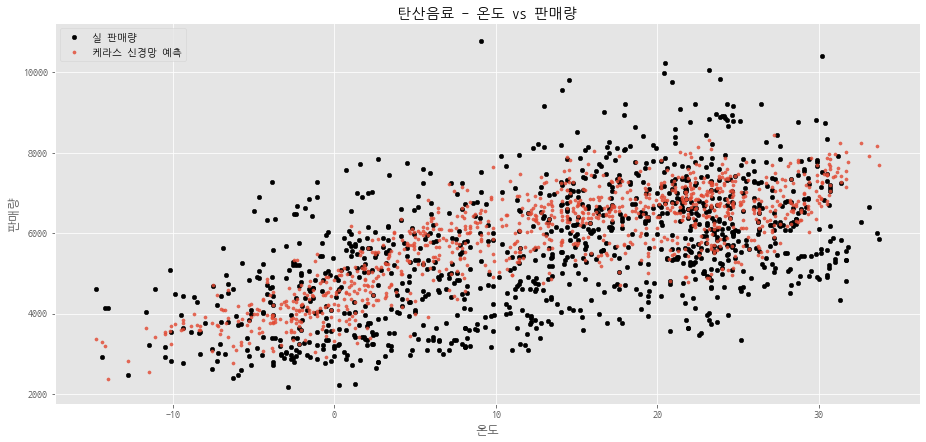

In [99]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_3','aircon',
#                                                     'date','PM10']
n=1
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.title('%s - %s vs 판매량' % (item, '온도') )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
# plt.xlabel('{}'.format(Xy.columns[n]))
plt.xlabel('온도')

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()

In [75]:
def airconall(x):
    if x[0]==1:
        return '좋음'
    elif x[1]==1:
        return '보통'
    elif x[2]==1:
        return '나쁨'
    elif x[3]==1:
        return '매우나쁨'

Xy['aircon'] =Xy[['공기상태_0','공기상태_1','공기상태_2','공기상태_3']].apply(airconall, axis=1)

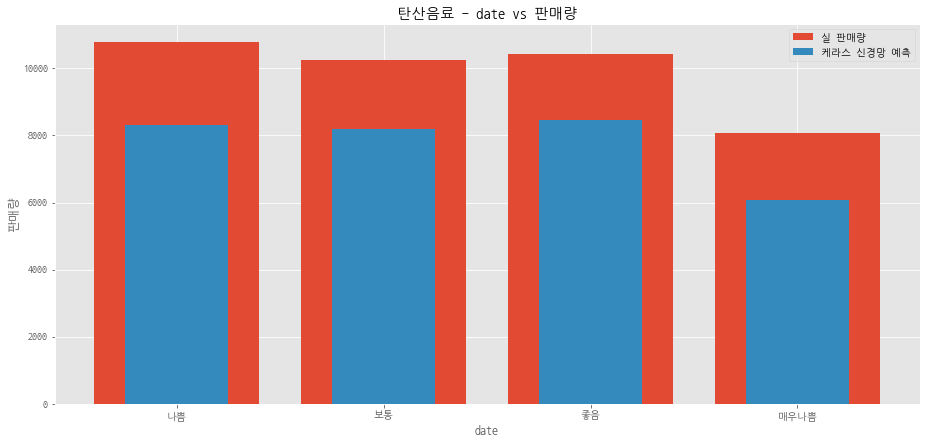

In [76]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_2', 'aircon']
# 1~11
n=11
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )

ind = np.arange(4)
plt.bar(Xy.aircon,result_df.qty, label = '실 판매량')
plt.bar(Xy.aircon,result_df.keras_qty, label = '케라스 신경망 예측',width = 0.5)
# plt.bar(Xy.aircon,result_df.rf_qty, label = 'RandomForest 예측')
# plt.bar(Xy.aircon,result_df.xgb_qty, label = 'XGBoosting 예측')
# plt.bar(Xy.aircon,result_df.lin_qty, label = '선형 예측')
# plt.bar(Xy.aircon,result_df.ridge_qty, label = 'Ridge 예측')
# plt.bar(Xy.aircon,result_df.ols_qty, label = 'OLS 예측')

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

In [77]:
tt = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']
print(tt)

['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']


In [78]:
Xy.head(2)
# result_df.head(2)
result_Xy = pd.concat([result_df, Xy[tt]],axis=1)
result_Xy.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_ridge,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon
0,2016-01-01,3480,4556.773926,3788.0,4345.414551,5047.003738,5126.687776,5045.480004,4890.712933,0.309418,...,0.473186,0.449851,0.405377,1.2,7.0,1.6,2.1,0,0,나쁨
1,2016-01-02,3103,5696.258789,4675.6,5267.722168,5337.988625,5409.328866,5336.833352,5287.264145,0.835726,...,0.743258,0.719895,0.703920,5.7,7.8,2.0,3.6,0,0,보통


In [79]:
result_Xy.columns

Index(['date', 'qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty',
       'lasso_qty', 'ols_qty', 'mape_keras', 'mape_rf', 'mape_xgb', 'mape_lin',
       'mape_ridge', 'mape_lasso', 'mape_ols', 'temp', 'cloud', 'wind',
       'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon'],
      dtype='object')

In [92]:
def tempCat(x):
    if x < -10:
        return 0
    elif x < 0:
        return 1
    elif x < 10:
        return 2
    elif x < 20:
        return 3
    elif x < 30:
        return 4
    else:
        return 5
    
w_seoul['temp_cat'] = w_seoul.temp.apply(tempCat)
XyAndPm10 = pd.merge(result_Xy, w_seoul[['date','temp_cat']], on='date', how='left')
XyAndPm10.head()

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon,temp_cat
0,2016-01-01,3480,4556.773926,3788.0,4345.414551,5047.003738,5126.687776,5045.480004,4890.712933,0.309418,...,0.449851,0.405377,1.2,7.0,1.6,2.1,0,0,나쁨,2
1,2016-01-02,3103,5696.258789,4675.6,5267.722168,5337.988625,5409.328866,5336.833352,5287.264145,0.835726,...,0.719895,0.703920,5.7,7.8,2.0,3.6,0,0,보통,2
2,2016-01-03,3089,5661.088379,4034.2,5132.363770,5434.610708,5472.137149,5433.286823,5357.762138,0.832661,...,0.758914,0.734465,6.5,7.5,1.8,2.2,0,0,나쁨,2
3,2016-01-04,3216,3639.061523,3469.9,4297.320312,4886.285596,4966.300559,4885.472285,4961.210926,0.131549,...,0.519115,0.542665,2.0,4.4,3.1,8.6,0,0,나쁨,2
4,2016-01-05,2878,3585.513184,3059.8,3647.629883,4700.550512,4824.573361,4699.684337,4547.035215,0.245835,...,0.632969,0.579929,-2.7,3.4,2.3,7.9,0,0,보통,1


In [93]:
p_df = pd.pivot_table(XyAndPm10[['date','qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 
                                 'ridge_qty','lasso_qty', 'ols_qty', 'temp_cat']],
                     values = ['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 
                               'lin_qty', 'ridge_qty','lasso_qty', 'ols_qty'],
                     index=['temp_cat'],
                     aggfunc = np.sum)
p_df = p_df.iloc[:,[4,0,1,2,3,5,6,7]]
p_df

,qty,keras_qty,lasso_qty,lin_qty,ols_qty,rf_qty,ridge_qty,xgb_qty
temp_cat,,,,,,,,
0,47721,4.220283e+04,4.685945e+04,4.686944e+04,4.846626e+04,49157.5,4.956333e+04,4.627500e+04
1,668550,6.370946e+05,7.201193e+05,7.201340e+05,7.105181e+05,683356.3,7.388496e+05,6.900305e+05
2,1240194,1.362436e+06,1.348152e+06,1.348145e+06,1.331068e+06,1369642.3,1.366830e+06,1.381552e+06
3,1617768,1.726923e+06,1.658034e+06,1.657991e+06,1.652468e+06,1760095.2,1.657541e+06,1.764212e+06
4,2275830,2.368364e+06,2.481960e+06,2.482051e+06,2.471409e+06,2421506.3,2.452053e+06,2.415946e+06
5,250437,2.981332e+05,3.112826e+05,3.112814e+05,3.007234e+05,296098.3,3.047296e+05,2.962223e+05


In [81]:
# 8개 판매량

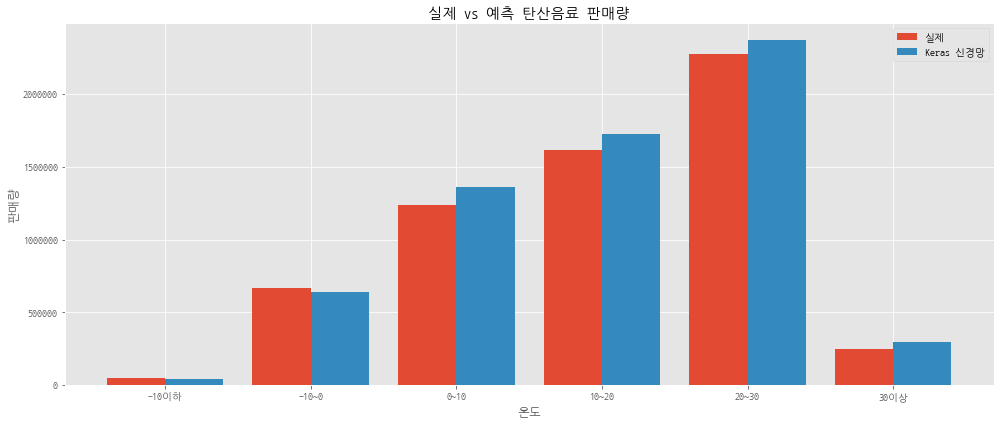

In [98]:
# 사이즈 변경 
rcParams['figure.figsize'] = 14, 6

# 공기상태 길이 만큼 x축 칸 생성
ind = np.arange(len(p_df.index))
# 바의 너비 설정
width = 0.4

# 한 그래프에 여러 값의 바그래프를 넣기 위한 그래프 객체 생성
fig, ax = plt.subplots()

# 각각의 그래프 생성
rects1 = ax.bar(ind - width/2, p_df.qty, width, label = '실제')
rects2 = ax.bar(ind + width/2, p_df.keras_qty, width, label = 'Keras 신경망')
# rects3 = ax.bar(ind - width*2, p_df.lasso_qty, width, label = 'Lasso')
# rects4 = ax.bar(ind - width*1, p_df.lin_qty, width, label = 'Linear')
# rects5 = ax.bar(ind + width*0, p_df.ols_qty, width, label = 'OLS')
# rects6 = ax.bar(ind + width*1, p_df.rf_qty, width, label = 'RandomForest')
# rects7 = ax.bar(ind + width*2, p_df.ridge_qty, width, label = 'Ridge')
# rects8 = ax.bar(ind + width*3, p_df.xgb_qty, width, label = 'XGB', color = 'green')

# 제목
ax.set_title('실제 vs 예측 %s 판매량'%item)

# y축
ax.set_ylabel('판매량')

# x축
ax.set_xticks(ind)

# x 값 이름
ax.set_xticklabels(('-10이하','-10~0','0~10','10~20','20~30','30이상'))
ax.set_xlabel('온도')

# 범례
ax.legend()

fig.tight_layout()
figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()